<a href="https://colab.research.google.com/github/nabdeep-patel/flare-cme-association/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sunpy[all] lime
from IPython.display import clear_output
clear_output()

# Notebook

A Coronal Mass Ejection (CME) throws magnetic flux and plasma from the Sun into interplanetary space. These eruptions are actually related to solar flares -- in fact, CMEs and solar flares are considered “a single magnetically driven event” ([Webb & Howard 2012](http://adsabs.harvard.edu/abs/2012LRSP....9....3W)), wherein a flare unassociated with a CME is called a confined or compact flare. <br>

In general, the more energetic a flare, the more likely it is to be associated with a CME ([Yashiro et al. 2005](http://adsabs.harvard.edu/abs/2005JGRA..11012S05Y)) -- but this is not, by any means, a rule. For example, [Sun et al. (2015)](http://adsabs.harvard.edu/abs/2015ApJ...804L..28S) found that the largest active region in the last 24 years, shown below, produced 6 X-class flares but not a single observed CME.<br>

In this notebook, we will be predicting whether or not a flaring active region will also emit a CME using a machine learning algorithm from the scikit-learn package called Support Vector Machine.

The analysis that follows is published in [Bobra & Ilonidis, 2016, <i> Astrophysical Journal</i>, 821, 127](http://adsabs.harvard.edu/abs/2016ApJ...821..127B). If you use any of this code, we ask that you cite Bobra & Ilonidis (2016).

Here is a video that explains the difference between a flare and a CME:

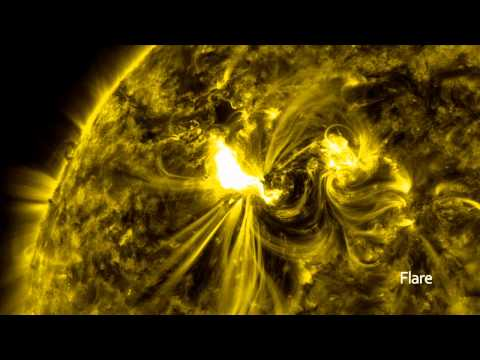

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("TWjtYSRlOUI")

To do this analysis, we'll look at every active region observed by the Helioseismic and Magnetic Imager instrument on NASA's Solar Dynamics Observatory (SDO) satellite over the last eight years. Each active region is characterized by a bunch of features. These features describe the magnetic field at the solar surface. One feature, for example, is the total energy contained within an active region. Another is the total flux through an active region. We have 18 features, all of which are calculated every 12 minutes throughout an active region's lifetime. See [Bobra et al., 2014](http://link.springer.com/article/10.1007%2Fs11207-014-0529-3) for more information on how we calculate these features. <br>

We'll then ascribe each active region to one of two classes:

1. The positive class contains flaring active regions that did produce a CME.
2. The negative class contains flaring active regions that did not produce a CME.

First, we'll import some modules.

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.mlab as mlab
import pandas as pd
import scipy.stats
import requests
import urllib
import json
from datetime import datetime as dt_obj
from datetime import timedelta
from sklearn import svm
import lime
from sklearn.model_selection import StratifiedKFold
from sunpy.time import TimeRange
from sunpy.net import Fido, attrs as a

Now we'll gather the data. The data come from three different places:

1. CME data from SOHO/LASCO and STEREO/SECCHI coronographs, which can be accesed from the [DONKI database](http://kauai.ccmc.gsfc.nasa.gov/DONKI/) at NASA Goddard. This tells us if an active region has produced a CME or not.
2. Flare data from the GOES flare catalog at NOAA, which can be accessed with the `sunpy.instr.goes.get_event_list()` function. This tells us if an active region produced a flare or not.
3. Active region data from the Solar Dynamics Observatory's Heliosesmic and Magnetic Imager instrument, which can be accessed from the [JSOC database](http://jsoc.stanford.edu/) via a JSON API. This gives us the features characterizing each active region.

## Step 1: Gathering data for the positive class

Let's first query the [DONKI database](http://kauai.ccmc.gsfc.nasa.gov/DONKI/) to get the data associated with the positive class. Be forewarned: there's a lot of data cleaning involved with building the positive class.

In [ ]:
# request the data
baseurl = "https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/FLR?"
t_start = "2010-05-01"
t_end = "2024-11-01"
url = baseurl+"startDate="+t_start+"&endDate="+t_end

# if there's no response at this time, print warning
response = requests.get(url)
if response.status_code != 200:
    print('cannot successfully get an http response')

In [ ]:
# read the data

print("Getting data from", url)
df = pd.read_json(url)

# select flares associated with a linked event (SEP or CME), and
# select only M or X-class flares
events_list = df.loc[df['classType'].str.contains("M|X") & ~df['linkedEvents'].isnull()]

# drop all rows that don't satisfy the above conditions
events_list = events_list.reset_index(drop=True)

Getting data from https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/FLR?startDate=2010-05-01&endDate=2024-11-01


In [ ]:
events_list.tail()

,flrID,catalog,instruments,beginTime,peakTime,endTime,classType,sourceLocation,activeRegionNum,note,submissionTime,versionId,link,linkedEvents
538,2024-10-25T07:23:00-FLR-001,M2M_CATALOG,[{'displayName': 'GOES-P: EXIS 1.0-8.0'}],2024-10-25T07:23Z,2024-10-25T07:33Z,2024-10-25T07:38Z,M1.1,S10E72,13873.0,,2024-10-25T11:09Z,1,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,[{'activityID': '2024-10-25T07:53:00-CME-001'}]
539,2024-10-26T05:57:00-FLR-001,M2M_CATALOG,[{'displayName': 'GOES-P: EXIS 1.0-8.0'}],2024-10-26T05:57Z,2024-10-26T06:23Z,2024-10-26T06:32Z,M9.5,S14E56,13873.0,The first short minor peak of a double peaked ...,2024-10-26T12:21Z,2,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,[{'activityID': '2024-10-26T06:48:00-CME-001'}...
540,2024-10-26T06:32:00-FLR-001,M2M_CATALOG,[{'displayName': 'GOES-P: EXIS 1.0-8.0'}],2024-10-26T06:32Z,2024-10-26T07:19Z,2024-10-26T07:56Z,X1.8,S16E60,13873.0,"The second, long duration, peak of a double pe...",2024-10-26T12:26Z,1,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,[{'activityID': '2024-10-26T06:48:00-CME-001'}...
541,2024-10-31T12:41:00-FLR-001,M2M_CATALOG,[{'displayName': 'GOES-P: EXIS 1.0-8.0'}],2024-10-31T12:41Z,2024-10-31T12:54Z,2024-10-31T13:03Z,M2.4,N26W35,13875.0,Some simultaneous brightening from AR 13877 (S...,2024-10-31T13:17Z,1,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,[{'activityID': '2024-10-31T13:48:00-CME-001'}]
542,2024-10-31T21:12:00-FLR-001,M2M_CATALOG,[{'displayName': 'GOES-P: EXIS 1.0-8.0'}],2024-10-31T21:12Z,2024-10-31T21:20Z,2024-10-31T21:27Z,X2.0,N16E28,13878.0,,2024-10-31T21:31Z,3,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,[{'activityID': '2024-10-31T22:36:00-CME-001'}]


In [ ]:
# drop the rows that aren't linked to CME events
for i in range(events_list.shape[0]):
    value = events_list.loc[i]['linkedEvents'][0]['activityID']
    if not "CME" in value:
        print(value, "not a CME, dropping row")
        events_list = events_list.drop([i])
events_list = events_list.reset_index(drop=True)

2011-08-09T08:40:00-SEP-001 not a CME, dropping row
2011-09-07T06:00:00-SEP-001 not a CME, dropping row
2011-09-24T20:45:00-SEP-001 not a CME, dropping row
2013-06-21T06:09:00-SEP-001 not a CME, dropping row
2015-03-06T19:20:00-SEP-001 not a CME, dropping row
2015-06-18T09:25:00-SEP-001 not a CME, dropping row
2015-06-21T20:35:00-SEP-001 not a CME, dropping row
2015-06-21T20:35:00-SEP-001 not a CME, dropping row
2023-07-18T01:00:00-SEP-002 not a CME, dropping row
2023-08-05T10:00:00-SEP-001 not a CME, dropping row
2024-01-22T13:00:00-SEP-001 not a CME, dropping row
2024-05-10T14:50:00-SEP-001 not a CME, dropping row
2024-09-09T20:55:00-SEP-002 not a CME, dropping row


Convert the `peakTime` column in the `events_list` dataframe from a string into a datetime object:

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def parse_tai_string(tstr):
    year = int(tstr[:4])
    month = int(tstr[5:7])
    day = int(tstr[8:10])
    hour = int(tstr[11:13])
    minute = int(tstr[14:16])
    return dt_obj(year, month, day, hour, minute)


for i in range(events_list.shape[0]):
    events_list['peakTime'].iloc[i] = parse_tai_string(
        events_list['peakTime'].iloc[i])

Check for Case 1: In this case, the CME and flare exist but NOAA active region number does not exist in the DONKI database.

In [ ]:
# Case 1: CME and Flare exist but NOAA active region number does not exist in DONKI database

number_of_donki_mistakes = 0  # count the number of DONKI mistakes
# create an empty array to hold row numbers to drop at the end
event_list_drops = []

for i in range(events_list.shape[0]):
    if (np.isnan(events_list.loc[i]['activeRegionNum'])):
        time = events_list['peakTime'].iloc[i]
        time_range = TimeRange(time, time)
        listofresults = Fido.search(a.Time(time_range),a.hek.EventType("FL"),a.hek.FL.GOESCls > "M1.0",a.hek.OBS.Observatory == "GOES")

        if len(listofresults["hek"]) == 0:
            print(events_list.loc[i]['classType'], "has no match in the GOES flare database ; dropping row.")
            event_list_drops.append(i)
            number_of_donki_mistakes += 1
            continue
        else:
            if (listofresults[0]['ar_noaanum'] == 0):
                print(events_list.loc[i]['activeRegionNum'], events_list.loc[i]
                    ['classType'], "has no match in the GOES flare database ; dropping row.")
                event_list_drops.append(i)
                number_of_donki_mistakes += 1
                continue
            else:
                print("Missing NOAA number:", events_list['activeRegionNum'].iloc[i], events_list['classType'].iloc[i],
                    events_list['peakTime'].iloc[i], "should be", listofresults[0]['ar_noaanum'][0], "; changing now.")
                events_list['activeRegionNum'].iloc[i] = listofresults[0]['ar_noaanum']
                number_of_donki_mistakes += 1

# Drop the rows for which there is no active region number in both the DONKI and GOES flare databases
events_list = events_list.drop(event_list_drops)
events_list = events_list.reset_index(drop=True)
print('There are', number_of_donki_mistakes, 'DONKI mistakes so far.')

Missing NOAA number: nan X1.4 2011-09-22 11:01:00 should be 11302 ; changing now.
Missing NOAA number: nan X1.3 2012-03-07 01:14:00 should be 11430 ; changing now.
Missing NOAA number: nan M6.3 2012-03-09 03:53:00 should be 11429 ; changing now.
Missing NOAA number: nan M5.1 2012-05-17 01:47:00 should be 11476 ; changing now.
Missing NOAA number: nan X1.1 2012-07-06 23:08:00 should be 11515 ; changing now.
Missing NOAA number: nan M6.2 2012-07-28 20:56:00 should be 11532 ; changing now.
Missing NOAA number: nan M1.7 2012-11-08 02:23:00 should be 11611 ; changing now.
Missing NOAA number: nan M1.2 2013-03-15 06:58:00 should be 11692 ; changing now.
Missing NOAA number: nan X1.6 2013-05-13 02:17:00 should be 11748 ; changing now.
Missing NOAA number: nan X2.8 2013-05-13 16:05:00 should be 11748 ; changing now.
Missing NOAA number: nan X3.2 2013-05-14 01:11:00 should be 11748 ; changing now.
Missing NOAA number: nan X1.2 2013-05-15 01:48:00 should be 11748 ; changing now.
Missing NOAA num

Now we grab all the data from the GOES database in preparation for checking Cases 2 and 3.

In [ ]:
t_start = "2010-05-01"
t_end = "2024-11-01"
# Grab all the data from the GOES database
time_range = TimeRange(t_start, t_end)
listofresults = Fido.search(a.Time(time_range),a.hek.EventType("FL"),a.hek.FL.GOESCls > "M1.0",a.hek.OBS.Observatory == "GOES")
print('Grabbed all the GOES data; there are', len(listofresults["hek"]), 'events.')

Grabbed all the GOES data; there are 1883 events.


Check for Case 2: In this case, the NOAA active region number is wrong in the DONKI database.

In [ ]:
# Case 2: NOAA active region number is wrong in DONKI database

# collect all the peak flares times in the NOAA database
peak_times_noaa = [item["event_peaktime"] for item in listofresults["hek"]]

for i in range(events_list.shape[0]):
    # check if a particular DONKI flare peak time is also in the NOAA database
    peak_time_donki = events_list['peakTime'].iloc[i]
    if peak_time_donki in peak_times_noaa:
        index = peak_times_noaa.index(peak_time_donki)
    else:
        continue
    # ignore NOAA active region numbers equal to zero
    if (listofresults["hek"][index]['ar_noaanum'] == 0):
        continue
    # if yes, check if the DONKI and NOAA active region numbers match up for this peak time
    # if they don't, flag this peak time and replace the DONKI number with the NOAA number
    if (listofresults["hek"][index]['ar_noaanum'] != int(events_list['activeRegionNum'].iloc[i])):
        print('Messed up NOAA number:', int(events_list['activeRegionNum'].iloc[i]), events_list['classType'].iloc[i],
              events_list['peakTime'].iloc[i], "should be", listofresults["hek"][index]['ar_noaanum'], "; changing now.")
        events_list['activeRegionNum'].iloc[i] = listofresults["hek"][index]['ar_noaanum']
        number_of_donki_mistakes += 1
print('There are', number_of_donki_mistakes, 'DONKI mistakes so far.')

Messed up NOAA number: 11943 X1.2 2014-01-07 18:32:00 should be 11944 ; changing now.
Messed up NOAA number: 12051 M1.2 2014-05-07 16:29:00 should be 12055 ; changing now.
Messed up NOAA number: 12160 M1.4 2014-07-01 11:23:00 should be 12106 ; changing now.
Messed up NOAA number: 12282 M2.4 2015-02-09 23:35:00 should be 12280 ; changing now.
Messed up NOAA number: 12321 M1.1 2015-04-23 10:07:00 should be 12322 ; changing now.
Messed up NOAA number: 12565 M7.6 2016-07-23 05:16:00 should be 12567 ; changing now.
Messed up NOAA number: 12565 M5.5 2016-07-23 05:31:00 should be 12567 ; changing now.
Messed up NOAA number: 13191 M6.0 2023-01-15 03:42:00 should be 13188 ; changing now.
Messed up NOAA number: 13312 M1.9 2023-05-22 13:37:00 should be 13314 ; changing now.
Messed up NOAA number: 13615 M9.4 2024-03-30 21:16:00 should be 13515 ; changing now.
Messed up NOAA number: 13730 M1.5 2024-07-03 07:41:00 should be 13729 ; changing now.
Messed up NOAA number: 13762 M2.0 2024-07-27 10:40:00 

Check for Case 3: In this case, the flare peak time is wrong in the DONKI database.

In [ ]:
# Case 3: The flare peak time is wrong in the DONKI database.

# create an empty array to hold row numbers to drop at the end
event_list_drops = []

active_region_numbers_noaa = [item["ar_noaanum"]
                              for item in listofresults["hek"]]
flare_classes_noaa = [item["fl_goescls"] for item in listofresults["hek"]]

for i in range(events_list.shape[0]):
    # check if a particular DONKI flare peak time is also in the NOAA database
    peak_time_donki = events_list['peakTime'].iloc[i]
    if not peak_time_donki in peak_times_noaa:
        active_region_number_donki = int(
            events_list['activeRegionNum'].iloc[i])
        flare_class_donki = events_list['classType'].iloc[i]
        flare_class_indices = [i for i, x in enumerate(
            flare_classes_noaa) if x == flare_class_donki]
        active_region_indices = [i for i, x in enumerate(
            active_region_numbers_noaa) if x == active_region_number_donki]
        common_indices = list(
            set(flare_class_indices).intersection(active_region_indices))
        if common_indices:
            print("Messed up time:", int(events_list['activeRegionNum'].iloc[i]), events_list['classType'].iloc[i],
                  events_list['peakTime'].iloc[i], "should be", peak_times_noaa[common_indices[0]], "; changing now.")
            events_list['peakTime'].iloc[i] = peak_times_noaa[common_indices[0]]
            number_of_donki_mistakes += 1
        if not common_indices:
            print("DONKI flare peak time",
                  events_list['peakTime'].iloc[i], "has no match; dropping row.")
            event_list_drops.append(i)
            number_of_donki_mistakes += 1

# Drop the rows for which the NOAA active region number and flare class associated with
# the messed-up flare peak time in the DONKI database has no match in the GOES flare database
events_list = events_list.drop(event_list_drops)
events_list = events_list.reset_index(drop=True)

# Create a list of corrected flare peak times
peak_times_donki = [events_list['peakTime'].iloc[i]
                    for i in range(events_list.shape[0])]

print('There are', number_of_donki_mistakes, 'DONKI mistakes so far.')

Messed up time: 11429 X1.1 2012-03-05 04:05:00 should be 2012-03-05 04:09:00.000 ; changing now.
DONKI flare peak time 2012-03-10 17:27:00 has no match; dropping row.
Messed up time: 11745 M5.0 2013-05-22 13:38:00 should be 2013-05-22 13:32:00.000 ; changing now.
DONKI flare peak time 2014-02-09 16:14:00 has no match; dropping row.
DONKI flare peak time 2014-05-06 22:09:00 has no match; dropping row.
Messed up time: 12127 M1.5 2014-08-01 18:12:00 should be 2014-08-01 18:13:00.000 ; changing now.
Messed up time: 12146 M2.0 2014-08-25 15:10:00 should be 2014-08-25 15:11:00.000 ; changing now.
DONKI flare peak time 2014-09-03 13:53:00 has no match; dropping row.
DONKI flare peak time 2014-09-09 00:28:00 has no match; dropping row.
Messed up time: 12172 M2.3 2014-09-23 23:15:00 should be 2014-09-23 23:16:00.000 ; changing now.
Messed up time: 12242 X1.8 2014-12-20 00:24:00 should be 2014-12-20 00:28:00.000 ; changing now.
DONKI flare peak time 2014-12-21 12:17:00 has no match; dropping row

This is our final table of events that fall into the positive class:

In [ ]:
events_list

,flrID,catalog,instruments,beginTime,peakTime,endTime,classType,sourceLocation,activeRegionNum,note,submissionTime,versionId,link,linkedEvents
0,2011-02-15T01:44:00-FLR-001,M2M_CATALOG,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-02-15T01:44Z,2011-02-15 01:56:00,2011-02-15T02:06Z,X2.2,S20W10,11158.0,,2015-07-16T19:24Z,2,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,[{'activityID': '2011-02-15T02:25:00-CME-001'}]
1,2011-02-24T07:23:00-FLR-001,M2M_CATALOG,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-02-24T07:23Z,2011-02-24 07:35:00,2011-02-24T07:42Z,M3.5,N14E87,11163.0,,2015-07-16T19:28Z,2,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,[{'activityID': '2011-02-24T08:00:00-CME-001'}]
2,2011-03-07T13:44:00-FLR-001,M2M_CATALOG,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-03-07T13:44Z,2011-03-07 14:30:00,2011-03-07T15:08Z,M2.0,N11E21,11166.0,,2013-07-18T13:28Z,1,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,[{'activityID': '2011-03-07T14:40:00-CME-001'}]
3,2011-03-07T19:43:00-FLR-001,M2M_CATALOG,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-03-07T19:43Z,2011-03-07 20:12:00,2011-03-07T21:40Z,M3.7,N30W48,11164.0,,2013-07-18T18:41Z,1,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,[{'activityID': '2011-03-07T20:12:00-CME-001'}]
4,2011-03-08T03:37:00-FLR-001,M2M_CATALOG,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-03-08T03:37Z,2011-03-08 03:58:00,2011-03-08T04:20Z,M1.5,S21E72,11171.0,,2013-07-18T19:11Z,1,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,[{'activityID': '2011-03-08T05:00:00-CME-001'}]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,2024-10-25T07:23:00-FLR-001,M2M_CATALOG,[{'displayName': 'GOES-P: EXIS 1.0-8.0'}],2024-10-25T07:23Z,2024-10-25 07:33:00,2024-10-25T07:38Z,M1.1,S10E72,13873.0,,2024-10-25T11:09Z,1,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,[{'activityID': '2024-10-25T07:53:00-CME-001'}]
457,2024-10-26T05:57:00-FLR-001,M2M_CATALOG,[{'displayName': 'GOES-P: EXIS 1.0-8.0'}],2024-10-26T05:57Z,2024-10-26 06:23:00,2024-10-26T06:32Z,M9.5,S14E56,13873.0,The first short minor peak of a double peaked ...,2024-10-26T12:21Z,2,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,[{'activityID': '2024-10-26T06:48:00-CME-001'}...
458,2024-10-26T06:32:00-FLR-001,M2M_CATALOG,[{'displayName': 'GOES-P: EXIS 1.0-8.0'}],2024-10-26T06:32Z,2024-10-26 07:19:00,2024-10-26T07:56Z,X1.8,S16E60,13873.0,"The second, long duration, peak of a double pe...",2024-10-26T12:26Z,1,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,[{'activityID': '2024-10-26T06:48:00-CME-001'}...
459,2024-10-31T12:41:00-FLR-001,M2M_CATALOG,[{'displayName': 'GOES-P: EXIS 1.0-8.0'}],2024-10-31T12:41Z,2024-10-31 12:54:00,2024-10-31T13:03Z,M2.4,N26W35,13875.0,Some simultaneous brightening from AR 13877 (S...,2024-10-31T13:17Z,1,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,[{'activityID': '2024-10-31T13:48:00-CME-001'}]


Now let's query the JSOC database to see if there are active region parameters at the time of the flare. First read the following file to map NOAA active region numbers to HARPNUMs (a HARP, or an HMI Active Region Patch, is the preferred numbering system for the HMI active regions as they appear in the magnetic field data before NOAA observes them in white light):

In [ ]:
answer = pd.read_csv('http://jsoc.stanford.edu/doc/data/hmi/harpnum_to_noaa/all_harps_with_noaa_ars.txt', sep=' ')

Now, let's determine at which time we'd like to predict CMEs. In general, many people try to predict a CME either 24 or 48 hours before it happens. We can report both in this study by setting a variable called `timedelayvariable`:

In [ ]:
timedelayvariable = 24

Now, we'll convert subtract `timedelayvariable` from the GOES Peak Time and re-format the datetime object into a string that JSOC can understand:

In [ ]:
t_rec = [(events_list['peakTime'].iloc[i] - timedelta(hours=timedelayvariable)
          ).strftime('%Y.%m.%d_%H:%M_TAI') for i in range(events_list.shape[0])]

Now we can grab the SDO data from the JSOC database by executing the JSON queries. We are selecting data that satisfies several criteria: The data has to be [1] disambiguated with a version of the disambiguation module greater than 1.1, [2] taken while the orbital velocity of the spacecraft is less than 3500 m/s, [3] of a high quality, and [4] within 70 degrees of central meridian. If the data pass all these tests, they are stuffed into one of two lists: one for the positive class (called CME_data) and one for the negative class (called no_CME_data).

In [ ]:
def get_the_jsoc_data(event_count, t_rec):
    """
    Parameters
    ----------
    event_count: number of events
                 int

    t_rec:       list of times, one associated with each event in event_count
                 list of strings in JSOC format ('%Y.%m.%d_%H:%M_TAI')

    """

    catalog_data = []
    classification = []

    for i in range(event_count):

        print("=====", i, "=====")
        # next match NOAA_ARS to HARPNUM
        idx = answer[answer['NOAA_ARS'].str.contains(
            str(int(listofactiveregions[i])))]

        # if there's no HARPNUM, quit
        if (idx.empty == True):
            print('skip: there are no matching HARPNUMs for',
                  str(int(listofactiveregions[i])))
            continue

        # construct jsoc_info queries and query jsoc database; we are querying for 25 keywords
        url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.sharp_720s["+str(
            idx.HARPNUM.values[0])+"]["+t_rec[i]+"][? (CODEVER7 !~ '1.1 ') and (abs(OBS_VR)< 3500) and (QUALITY<65536) ?]&op=rs_list&key=USFLUX,MEANGBT,MEANJZH,MEANPOT,SHRGT45,TOTUSJH,MEANGBH,MEANALP,MEANGAM,MEANGBZ,MEANJZD,TOTUSJZ,SAVNCPP,TOTPOT,MEANSHR,AREA_ACR,R_VALUE,ABSNJZH"
        response = requests.get(url)

        # if there's no response at this time, quit
        if response.status_code != 200:
            print('skip: cannot successfully get an http response')
            continue

        # read the JSON output
        data = response.json()

        # if there are no data at this time, quit
        if data['count'] == 0:
            print('skip: there are no data for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        # check to see if the active region is too close to the limb
        # we can compute the latitude of an active region in stonyhurst coordinates as follows:
        # latitude_stonyhurst = CRVAL1 - CRLN_OBS
        # for this we have to query the CEA series (but above we queried the other series as the CEA series does not have CODEVER5 in it)

        url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.sharp_cea_720s["+str(
            idx.HARPNUM.values[0])+"]["+t_rec[i]+"][? (abs(OBS_VR)< 3500) and (QUALITY<65536) ?]&op=rs_list&key=CRVAL1,CRLN_OBS"
        response = requests.get(url)

        # if there's no response at this time, quit
        if response.status_code != 200:
            print('skip: failed to find CEA JSOC data for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        # read the JSON output
        latitude_information = response.json()

        # if there are no data at this time, quit
        if latitude_information['count'] == 0:
            print('skip: there are no data for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        CRVAL1 = float(latitude_information['keywords'][0]['values'][0])
        CRLN_OBS = float(latitude_information['keywords'][1]['values'][0])
        if (np.absolute(CRVAL1 - CRLN_OBS) > 70.0):
            print('skip: latitude is out of range for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        if ('MISSING' in str(data['keywords'])):
            print('skip: there are some missing keywords for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        print('accept NOAA Active Region number', str(int(
            listofactiveregions[i])), 'and HARPNUM', idx.HARPNUM.values[0], 'at time', t_rec[i])

        individual_flare_data = []
        for j in range(18):
            individual_flare_data.append(
                float(data['keywords'][j]['values'][0]))

        catalog_data.append(list(individual_flare_data))

        single_class_instance = [idx.HARPNUM.values[0], str(
            int(listofactiveregions[i])), listofgoesclasses[i], t_rec[i]]
        classification.append(single_class_instance)

    return catalog_data, classification

Now we prepare the data to be fed into the function:

In [ ]:
listofactiveregions = list(events_list['activeRegionNum'].values.flatten())
listofgoesclasses = list(events_list['classType'].values.flatten())

And call the function:

In [ ]:
positive_result = get_the_jsoc_data(events_list.shape[0], t_rec)

===== 0 =====
accept NOAA Active Region number 11158 and HARPNUM 377 at time 2011.02.14_01:56_TAI
===== 1 =====
skip: there are no data for HARPNUM 392 at time 2011.02.23_07:35_TAI
===== 2 =====
accept NOAA Active Region number 11166 and HARPNUM 401 at time 2011.03.06_14:30_TAI
===== 3 =====
accept NOAA Active Region number 11164 and HARPNUM 393 at time 2011.03.06_20:12_TAI
===== 4 =====
skip: there are no data for HARPNUM 415 at time 2011.03.07_03:58_TAI
===== 5 =====
accept NOAA Active Region number 11226 and HARPNUM 637 at time 2011.06.06_06:41_TAI
===== 6 =====
accept NOAA Active Region number 11261 and HARPNUM 750 at time 2011.08.02_13:48_TAI
===== 7 =====
accept NOAA Active Region number 11261 and HARPNUM 750 at time 2011.08.03_03:57_TAI
===== 8 =====
accept NOAA Active Region number 11283 and HARPNUM 833 at time 2011.09.06_22:38_TAI
===== 9 =====
skip: there are no data for HARPNUM 892 at time 2011.09.21_11:01_TAI
===== 10 =====
skip: there are no data for HARPNUM 892 at time 20

Here is the number of events associated with the positive class:

In [ ]:
positive_a = pd.DataFrame(positive_result[0], columns=['USFLUX', 'MEANGBT', 'MEANJZH', 'MEANPOT', 'SHRGT45', 'TOTUSJH', 'MEANGBH', 'MEANALP', 'MEANGAM', 'MEANGBZ', 'MEANJZD', 'TOTUSJZ', 'SAVNCPP', 'TOTPOT', 'MEANSHR', 'AREA_ACR', 'R_VALUE', 'ABSNJZH'])
positive_b = pd.DataFrame(positive_result[1], columns=['HARPNUM', 'NOAA_ARS', 'GOES_Class', 'Peak_Time'])
positive_data = pd.concat([positive_a, positive_b], axis=1)
positive_data.to_csv('/content/positive_2018.csv', index=False)

In [ ]:
positive_data

,USFLUX,MEANGBT,MEANJZH,MEANPOT,SHRGT45,TOTUSJH,MEANGBH,MEANALP,MEANGAM,MEANGBZ,...,SAVNCPP,TOTPOT,MEANSHR,AREA_ACR,R_VALUE,ABSNJZH,HARPNUM,NOAA_ARS,GOES_Class,Peak_Time
0,2.246101e+22,107.736,0.021724,15533.100,54.882,2975.118,77.983,0.041413,59.541,117.582,...,1.226148e+13,7.077275e+23,50.329,945.314636,4.805,745.287,377,11158,X2.2,2011.02.14_01:56_TAI
1,2.235615e+22,93.863,-0.001943,10914.060,44.178,1636.710,56.639,-0.003942,50.680,99.163,...,3.884153e+12,4.733711e+23,43.479,961.502686,4.303,63.441,401,11166,M2.0,2011.03.06_14:30_TAI
2,6.039302e+22,91.233,0.007535,9912.353,29.044,4229.148,49.560,0.015028,41.150,100.010,...,3.430647e+13,1.074422e+24,35.873,1934.446167,4.865,615.008,393,11164,M3.7,2011.03.06_20:12_TAI
3,2.384940e+22,109.706,0.009620,3703.910,13.500,1505.331,47.602,0.030907,34.321,110.939,...,1.969386e+13,1.879337e+23,28.525,970.551636,3.971,367.530,637,11226,M2.5,2011.06.06_06:41_TAI
4,1.989983e+22,109.891,0.032849,12062.610,44.090,2547.054,73.681,0.079865,53.270,115.866,...,4.460671e+13,5.269515e+23,43.929,1259.099854,4.777,1080.528,750,11261,M6.0,2011.08.02_13:48_TAI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,1.062607e+23,83.529,0.004607,5248.720,20.029,5844.675,36.500,0.013047,36.412,87.189,...,2.677428e+13,1.152347e+24,30.441,4454.395020,5.533,761.650,12094,13869,X3.3,2024.10.23_03:57_TAI
281,1.560546e+23,81.802,0.000099,6717.811,24.897,8744.366,39.326,0.000230,39.709,87.290,...,1.640436e+13,2.124051e+24,33.022,6325.635254,5.345,23.468,12094,13873,M1.1,2024.10.24_07:33_TAI
282,1.790346e+23,85.620,-0.001078,6688.355,25.359,10673.055,41.600,-0.002732,40.301,89.437,...,1.466640e+13,2.426725e+24,33.259,7136.318848,5.305,294.612,12094,13873,M9.5,2024.10.25_06:23_TAI
283,1.804871e+23,85.226,-0.000415,6687.689,25.338,10542.597,41.406,-0.001073,40.280,88.964,...,2.161353e+13,2.456032e+24,33.402,7213.519043,5.296,114.845,12094,13873,X1.8,2024.10.25_07:19_TAI


In [ ]:
CME_data = positive_result[0]
positive_class = positive_result[1]
print("There are", len(CME_data), "CME events in the positive class.")

There are 285 CME events in the positive class.


## Step 2: Gathering data for the negative class

To gather the examples for the negative class, we only need to:

1. Query the GOES database for all the M- and X-class flares during our time of interest, and
2. Select the ones that are not associated with a CME.

In [ ]:
# select peak times that belong to both classes
all_peak_times = np.array([(listofresults["hek"][i]['event_peaktime'])
                           for i in range(len(listofresults["hek"]))])

negative_class_possibilities = []
counter_positive = 0
counter_negative = 0
for i in range(len(listofresults["hek"])):
    this_peak_time = all_peak_times[i]
    if (this_peak_time in peak_times_donki):
        counter_positive += 1
    else:
        counter_negative += 1
        this_instance = [listofresults["hek"][i]['ar_noaanum'],
                         listofresults["hek"][i]['fl_goescls'], listofresults["hek"][i]['event_peaktime']]
        negative_class_possibilities.append(this_instance)
print("There are", counter_positive, "events in the positive class.")
print("There are", counter_negative, "events in the negative class.")

There are 472 events in the positive class.
There are 1411 events in the negative class.


Again, we compute times that are one day before the flare peak time and convert it into a string that JSOC can understand:

In [ ]:
t_rec = np.array([(negative_class_possibilities[i][2] - timedelta(hours=timedelayvariable)
                   ).strftime('%Y.%m.%d_%H:%M_TAI') for i in range(len(negative_class_possibilities))])

And again, we query the JSOC database to see if these data are present:

In [ ]:
listofactiveregions = list(negative_class_possibilities[i][0] for i in range(counter_negative))
listofgoesclasses = list(negative_class_possibilities[i][1] for i in range(counter_negative))

In [ ]:
negative_resulta = get_the_jsoc_data(counter_negative, t_rec)

===== 0 =====
accept NOAA Active Region number 11069 and HARPNUM 8 at time 2010.05.04_17:19_TAI
===== 1 =====
skip: there are no data for HARPNUM 54 at time 2010.06.11_00:57_TAI
===== 2 =====
accept NOAA Active Region number 11112 and HARPNUM 211 at time 2010.10.15_19:12_TAI
===== 3 =====
skip: latitude is out of range for HARPNUM 245 at time 2010.11.03_23:58_TAI
===== 4 =====
skip: latitude is out of range for HARPNUM 245 at time 2010.11.03_23:58_TAI
===== 5 =====
skip: latitude is out of range for HARPNUM 245 at time 2010.11.05_15:36_TAI
===== 6 =====
accept NOAA Active Region number 11149 and HARPNUM 345 at time 2011.01.27_01:03_TAI
===== 7 =====
accept NOAA Active Region number 11153 and HARPNUM 362 at time 2011.02.08_01:31_TAI
===== 8 =====
accept NOAA Active Region number 11158 and HARPNUM 377 at time 2011.02.12_17:38_TAI
===== 9 =====
accept NOAA Active Region number 11158 and HARPNUM 377 at time 2011.02.13_17:26_TAI
===== 10 =====
accept NOAA Active Region number 11161 and HARP

Here is the number of events associated with the negative class:

In [ ]:
negative_a = pd.DataFrame(negative_resulta[0], columns=['USFLUX', 'MEANGBT', 'MEANJZH', 'MEANPOT', 'SHRGT45', 'TOTUSJH', 'MEANGBH', 'MEANALP', 'MEANGAM', 'MEANGBZ', 'MEANJZD', 'TOTUSJZ', 'SAVNCPP', 'TOTPOT', 'MEANSHR', 'AREA_ACR', 'R_VALUE', 'ABSNJZH'])
negative_b = pd.DataFrame(negative_resulta[1], columns=['HARPNUM', 'NOAA_ARS', 'GOES_Class', 'Peak_Time'])
negative_data = pd.concat([negative_a, negative_b], axis=1)
negative_data.to_csv('/content/negative_2018.csv', index=False)

In [ ]:
negative_data

,USFLUX,MEANGBT,MEANJZH,MEANPOT,SHRGT45,TOTUSJH,MEANGBH,MEANALP,MEANGAM,MEANGBZ,...,SAVNCPP,TOTPOT,MEANSHR,AREA_ACR,R_VALUE,ABSNJZH,HARPNUM,NOAA_ARS,GOES_Class,Peak_Time
0,5.987544e+21,112.002,-0.024196,5501.074,25.269,720.336,62.781,-0.067238,43.847,125.326,...,9.859024e+12,7.265489e+22,36.054,171.006271,4.072,240.634,8,11069,M1.2,2010.05.04_17:19_TAI
1,1.104408e+22,128.494,0.000534,2971.182,12.117,855.488,59.704,0.001917,35.838,128.672,...,7.092123e+12,7.395334e+22,27.692,703.612671,3.707,10.009,211,11112,M2.9,2010.10.15_19:12_TAI
2,1.812796e+22,61.379,0.005562,7593.361,24.858,878.336,32.508,0.012794,40.577,68.417,...,8.784931e+12,2.608914e+23,29.979,515.142334,4.015,143.879,345,11149,M1.3,2011.01.27_01:03_TAI
3,1.017101e+22,84.182,-0.002347,3373.081,11.460,536.272,40.112,-0.006268,32.987,88.180,...,1.490940e+12,6.688043e+22,26.689,240.660339,3.782,35.038,362,11153,M1.9,2011.02.08_01:31_TAI
4,5.466512e+21,121.227,-0.001571,5202.920,34.474,497.171,78.803,-0.004505,53.747,119.240,...,1.266448e+12,6.762531e+22,40.947,302.568970,3.473,15.378,377,11158,M6.6,2011.02.12_17:38_TAI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,1.249151e+23,112.155,-0.002390,10825.290,28.936,9091.145,56.414,-0.004075,41.643,119.929,...,1.172083e+13,2.170356e+24,34.840,8459.094727,5.062,360.843,12094,13869,M1.2,2024.10.27_14:44_TAI
750,1.081189e+23,109.247,-0.003565,10536.930,31.711,7737.148,56.151,-0.006695,43.762,115.667,...,8.301929e+12,1.971573e+24,36.673,7948.322266,4.961,502.214,12094,13873,M1.1,2024.10.28_16:33_TAI
751,6.244102e+22,77.040,-0.023672,19092.970,31.367,4295.733,43.265,-0.031920,41.071,84.909,...,4.492605e+13,1.720882e+24,35.413,2649.689941,4.887,1606.504,12160,13878,M7.2,2024.10.29_20:53_TAI
752,6.870547e+22,79.695,-0.019042,17385.150,30.879,4611.801,41.817,-0.027868,40.930,86.393,...,3.549734e+13,1.821178e+24,35.454,2678.618408,4.751,1501.977,12160,13878,M1.3,2024.10.30_09:37_TAI


In [ ]:
no_CME_data = negative_resulta[0]
negative_class = negative_resulta[1]
print("There are", len(no_CME_data), "no-CME events in the negative class.")

There are 754 no-CME events in the negative class.


In [ ]:
no_cme = np.array(no_CME_data)
no_cme.shape

(754, 18)

## Step 3: Feature selection

Some of the features within a data set may be powerful for distinguishing between the positive and negative class, whereas others may be redundant or irrelevant. To identify features in the former category, we use a univariate feature selection method, which is implemented in the feature selection module of the scikit-learn library, for feature scoring.

To improve the performance of the feature selection algorithm, we'll normalize each feature so that they lie within similar ranges. To do this, we subtract from every feature its median value and divide by its standard deviation.

In [ ]:
data = np.vstack([CME_data, no_CME_data])

In [ ]:
def normalize_the_data(flare_data):
    flare_data = np.array(flare_data)
    n_elements = flare_data.shape[0]
    for j in range(flare_data.shape[1]):
        standard_deviation_of_this_feature = np.std(flare_data[:, j])
        median_of_this_feature = np.median(flare_data[:, j])
        for i in range(n_elements):
            flare_data[i, j] = (
                flare_data[i, j] - median_of_this_feature) / (standard_deviation_of_this_feature)
    return flare_data

data = normalize_the_data(data)
no_CME_data = normalize_the_data(no_CME_data)
CME_data = normalize_the_data(CME_data)

print("There are", no_CME_data.shape[0], "flares with no associated CMEs.")
print("There are", CME_data.shape[0], "flares with associated CMEs.")

There are 754 flares with no associated CMEs.
There are 285 flares with associated CMEs.


Let's look at the distribution of one feature for the active regions that both flared and produced a CME (green) and for the active regions that flared but did not produce a CME (red). You can change the value of `i` in the code block below to see that some features are totally useless as there is barely any difference in the distributions for the positive and negative class. As such, we can throw such features out of our sample. It's a good idea to do some feature selection before running the SVM, so as to reduce noise (in this case, with only 18 features, there's not too much noise to begin with).

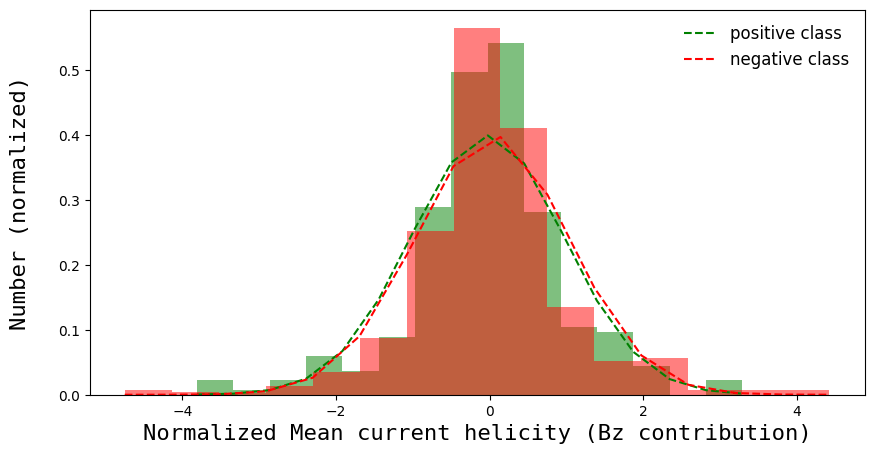

In [ ]:
sharps = ['Total unsigned flux', 'Mean gradient of total field',
          'Mean current helicity (Bz contribution)', 'Mean photospheric magnetic free energy',
          'Fraction of Area with Shear > 45 deg', 'Total unsigned current helicity',
          'Mean gradient of horizontal field', 'Mean characteristic twist parameter, alpha',
          'Mean angle of field from radial', 'Mean gradient of vertical field',
          'Mean vertical current density', 'Total unsigned vertical current',
          'Sum of the modulus of the net current per polarity',
          'Total photospheric magnetic free energy density', 'Mean shear angle',
          'Area of strong field pixels in the active region', 'Sum of flux near polarity inversion line',
          'Absolute value of the net current helicity','MTOT','MNET','MPOS_TOT','MNEG_TOT','MMEAN','MSTDEV','MSKEW','MKURT']

i = 2

# For the positive class (green)
mu_fl = np.mean(CME_data[:, i])
sigma_fl = np.std(CME_data[:, i])
num_bins = 15
n_fl, bins_fl, patches_fl = plt.hist(
    CME_data[:, i], num_bins,density =True , facecolor='green', alpha=0.5)
y_fl = scipy.stats.norm.pdf(bins_fl, mu_fl, sigma_fl)
plt.plot(bins_fl, y_fl, 'g--', label='positive class')

# For the negative class (red)
mu_nofl = np.mean(no_CME_data[:, i])
sigma_nofl = np.std(no_CME_data[:, i])
n_nofl, bins_nofl, patches_nofl = plt.hist(
    no_CME_data[:, i], num_bins, density =True, facecolor='red', alpha=0.5)
y_nofl = scipy.stats.norm.pdf(bins_nofl, mu_nofl, sigma_nofl)
plt.plot(bins_nofl, y_nofl, 'r--', label='negative class')

text_style = dict(fontsize=16, fontdict={'family': 'monospace'})
plt.xlabel('Normalized '+sharps[i], **text_style)
plt.ylabel('Number (normalized)', labelpad=20, **text_style)
fig = plt.gcf()
fig.set_size_inches(10, 5)
fig.savefig('fscore_tmp.png', bbox_inches='tight')
legend = plt.legend(loc='upper right', fontsize=12, framealpha=0.0, title='')
legend.get_frame().set_linewidth(0.0)

Now we will compute the Univariate F-score for feature selection. It is a very simple method: the F-score measures the distance between the two distributions for a given feature (inter-class distance), divided by the sum of the variances for this feature (intra-class distance). We can use the `sklearn.feature_selection` module to do this:

In [ ]:
# import the feature selection method
from sklearn.feature_selection import SelectKBest, f_classif
# select the number of features
N_features = 18
Nfl = CME_data.shape[0]
Nnofl = no_CME_data.shape[0]
yfl = np.ones(Nfl)
ynofl = np.zeros(Nnofl)
# k is the number of features
selector = SelectKBest(f_classif, k=N_features)
selector.fit(np.concatenate((CME_data, no_CME_data), axis=0),
             np.concatenate((yfl, ynofl), axis=0))
scores = selector.scores_
print(scores)

[1.87522363e-03 1.39153757e-01 7.54255351e-01 2.51778800e+00
 2.92629777e-02 1.38860516e+00 2.96837377e-01 9.63061873e-01
 4.14833660e-01 2.50974564e+00 2.31319775e-01 8.00794235e-01
 3.21624082e-01 2.37513913e+00 1.67136701e-01 5.89614707e-03
 1.50596782e+00 9.70754701e-02]


It's not easy to interpret the scores in this fashion, so let's plot the results. The higher the Univariate Fisher Score, the more predictive the feature.

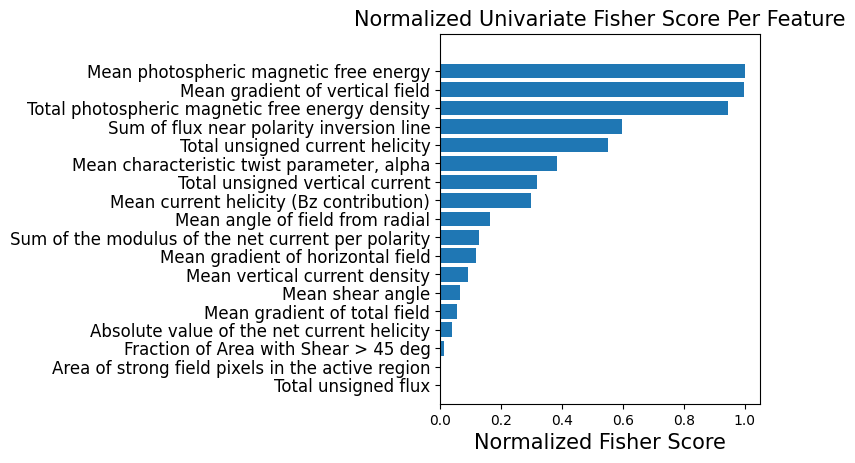

In [ ]:
plt.clf()
order = np.argsort(scores)
orderedsharps = [sharps[i] for i in order]
y_pos2 = np.arange(18)
plt.barh(y_pos2, sorted(scores/np.max(scores)))
plt.ylim((-1, 19))
plt.yticks(y_pos2, orderedsharps, fontsize=12)
plt.xlabel('Normalized Fisher Score', fontsize=15)
plt.title('Normalized Univariate Fisher Score Per Feature', fontsize=15)
plt.subplots_adjust(left=0.5, right=1.0)
fig = plt.gcf()
plt.show()

## Step 4: The support vector machine

Now we initialize the support vector machine on the data. The SVM uses non-linear decision functions to map the feature space into a higher-dimensional space, where the positive and negative examples can be separated linearly by a hyperplane. <br>

This is incredibly non-intuitive. But we can think of a simpler example. Suppose we had two classes: CME-producing and non-CME producing active regions. And suppose we had two features: the total flux in these regions, and the total area of these regions. We could construct a two-dimentional feature space, where we plot the flux against the area of each active region. Positive examples could be indicated by an X and negatives ones by an O. In theory, if our data behaved well, we could draw a line between these classess. <br>

Since we have 18 features, the SVM constructs an 18-dimensional feature space. In this feature space, the decision boundary separating the positive and negative examples may be non-linear. As such, the algorithm then enlarges this 18-dimensional feature space (using the function indicated by the `kernel` parameter in the [`svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) function) into a higher-dimensional feature space wherein it is possible to linearly separate the positive and negatives classes. There are lots of people trying to work on how to [visualize these multi-dimensional feature spaces](https://github.com/tmadl/highdimensional-decision-boundary-plot), which is an active area of research.

In [ ]:
Nfl = CME_data.shape[0]
Nnofl = no_CME_data.shape[0]
number_of_examples = Nfl + Nnofl
C = 4.0
gamma = 0.075
class_weight = 'balanced'
clf = svm.SVC(C=C, gamma=gamma, kernel='rbf', class_weight=class_weight,
              cache_size=500, max_iter=-1, shrinking=True, tol=1e-8, probability=True)

## Step 5: Stratified k-folds cross-validation

Now we run and evaluate the performance of the SVM. There are lots of different ways to evaluate the performance of a classifier, which we discuss in Section 4 of [Bobra & Couvidat (2015)](https://arxiv.org/abs/1411.1405). We're going to choose a metric called the True Skill Score, or the TSS, which we can calculate from four quantities: true positives, true negatives, false positives, and false negatives. We prefer the TSS to all the other metrics as it is insensitive to the class imbalance ratio and thus best for comparison to other groups. The TSS is symmetrically distributed about 0: i.e., it goes from [-1, 1] where 0 represents no skill and a negative value represents a perverse prediction. Thus we are able to predict CMEs in a fashion better than randomly guessing. Here we define a confusion table to measure the performance of our binary classification: <br>

In [ ]:
def confusion_table(pred, labels):
    """
    computes the number of TP, TN, FP, FN events given the arrays with predictions and true labels
    and returns the true skill score

    Args:
    pred: np array with predictions (1 for flare, 0 for nonflare)
    labels: np array with true labels (1 for flare, 0 for nonflare)

    Returns: true negative, false positive, true positive, false negative
    """
    Nobs = len(pred)
    TN = 0.
    TP = 0.
    FP = 0.
    FN = 0.
    for i in range(Nobs):
        if (pred[i] == 0 and labels[i] == 0):
            TN += 1
        elif (pred[i] == 1 and labels[i] == 0):
            FP += 1
        elif (pred[i] == 1 and labels[i] == 1):
            TP += 1
        elif (pred[i] == 0 and labels[i] == 1):
            FN += 1
        else:
            print("Error! Observation could not be classified.")
    return TN, FP, TP, FN

Now we run the SVM on our data and cross-validate our results. In our case, the positive sample size is quite small (both objectively and compared to the negative sample size). Therefore, we use a stratified k-folds cross-validation method, which makes k partitions of the data set and uses k-1 folds for training the SVM and 1 fold for testing the trained SVM. The stratification preserves the ratio of positive to negative examples per fold. Then we can permute over the partitions such that each partition eventually makes its way into the testing set. For each individual testing set, we can calculate a skill score. Then we can average the skill scores over the total number of testing sets.

To compute the TSS, we must first select a value of k. k can be arbitrarily defined and take any value between 2 and `number_of_examples`, so we can explore this parameter space. As k approaches `number_of_examples`, the k-fold method reduces to the Leave One Out method, in which only one example is in the testing set and all other examples are in the training set. The literature suggests this method is not the best, so we can stray away from high values of k. Many studies (e.g. [Kohavi, 1995](http://web.cs.iastate.edu/~jtian/cs573/Papers/Kohavi-IJCAI-95.pdf)) recommend the stratified 10-fold cross-validation to reduce variance and bias. Here, we test their recommendation by computing the TSS using 50 k values, ranging from 2 to 52.

In [ ]:
ydata = np.hstack([np.ones(Nfl),np.zeros(Nnofl)])

In [ ]:
# lists to hold the TSS and standard deviation of the TSS
array_of_avg_TSS = np.ndarray([50])
array_of_std_TSS = np.ndarray([50])

# xdata are the examples
# ydata are the labels
xdata = data

# mdata contain metadata about the active region that will be useful
# when we interpret the results using LIME
mdata = np.concatenate((CME_data, no_CME_data), axis=0)

# compute the TSS for a variety of k ranging from 2 to 52
# this is to see how the TSS varies as a function of k, and to test if k=10 really makes sense
for k in range(2, 52):
    skf = StratifiedKFold(n_splits=k, shuffle=True,random_state = 42)
    these_TSS_for_this_k = []
    for train_index, test_index in skf.split(xdata, ydata):
        # xtrain are the examples in the training set
        xtrain = xdata[train_index]
        # ytrain are the labels in the training set
        ytrain = ydata[train_index]
        # xtest are the examples in the testing set
        xtest = xdata[test_index]
        ytest = ydata[test_index]    # ytest are the labels in the testing set
        # metadata useful for interpreting with LIME
        mtrain = mdata[train_index]
        # metadata useful for interpreting with LIME
        mtest = mdata[test_index]
        clf.fit(xtrain, ytrain)
        TN, FP, TP, FN = confusion_table(clf.predict(xtest), ytest)
        if (((TP+FN) == 0.0) or (FP+TN) == 0.0):
            these_TSS_for_this_k.append(np.nan)
            continue
        else:
            these_TSS_for_this_k.append(TP/(TP+FN) - FP/(FP+TN))
    TSS_k = np.array(these_TSS_for_this_k)
    array_of_avg_TSS[k-2] = np.mean(TSS_k)
    array_of_std_TSS[k-2] = np.std(TSS_k)

Now we can plot the mean TSS per k, using the standard deviation as the error in the TSS. We see that for high values of k, the standard deviation in the TSS can be greater than the mean. These points are indicated in blue.

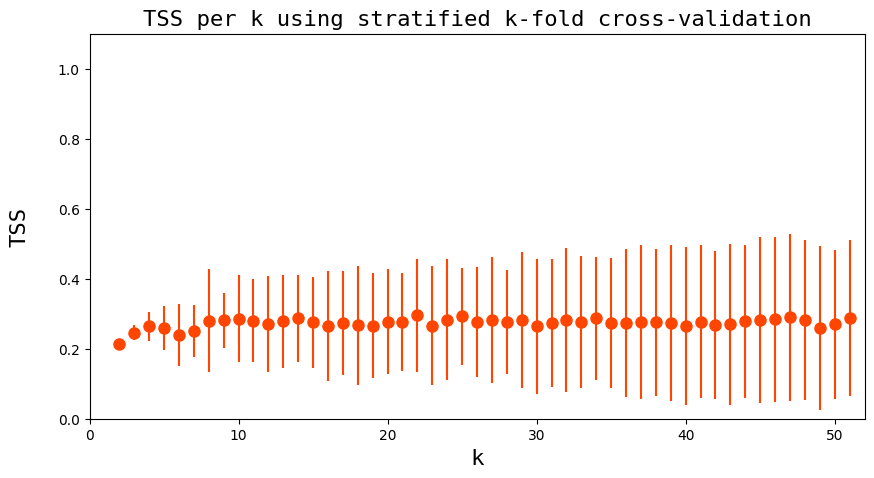

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))      # define the size of the figure
orangered = (1.0, 0.27, 0, 1.0)              # create an orange-red color
cornblue = (0.39, 0.58, 0.93, 1.0)           # create a cornflower-blue color

# define some style elements
marker_style_red = dict(linestyle='', markersize=8,
                        fillstyle='full', color=orangered, markeredgecolor=orangered)
marker_style_blue = dict(linestyle='', markersize=8,
                         fillstyle='full', color=cornblue, markeredgecolor=cornblue)
text_style = dict(fontsize=16, fontdict={'family': 'monospace'})

# ascribe the data to the axes
k = np.arange(50)+2
for i in range(50):
    if (array_of_avg_TSS[i] > array_of_std_TSS[i]):
        ax.errorbar(k[i], array_of_avg_TSS[i],
                    yerr=array_of_std_TSS[i], linestyle='', color=orangered)
        ax.plot(k[i], array_of_avg_TSS[i], 'o', **marker_style_red)
    if (array_of_avg_TSS[i] <= array_of_std_TSS[i]):
        ax.errorbar(k[i], array_of_avg_TSS[i],
                    yerr=array_of_std_TSS[i], linestyle='', color=cornblue)
        ax.plot(k[i], array_of_avg_TSS[i], 'o', **marker_style_blue)

# set plot limits
plt.xlim(xmax=52, xmin=0)
plt.ylim(ymax=1.1, ymin=0)

# label the axes and the plot
ax.set_xlabel('k', **text_style)
ax.set_ylabel('TSS', labelpad=20, **text_style)
plt.title(r'TSS per k using stratified k-fold cross-validation', **text_style)
fig = plt.gcf()
fig.set_size_inches(10, 5)

As such, we confirm that high k-values result in a high variance. We find it reasonable to use the stratified 10-fold cross-validation method to compute the TSS and will follow this recommendation. Therefore we report this score as our final result:

In [ ]:
print("The TSS equals", array_of_avg_TSS[9],
      "plus or minus", array_of_std_TSS[9], ".")

The TSS equals 0.28020209969059073 plus or minus 0.11840679408014568 .


## Addendum : Local Interpretable Model-Agnostic Explanations (LIME)

Machine-learning is a powerful technique that can help us predict CMEs. However, our goal is not only to predict CMEs, but also to quantitatively understand which signatures indicate the imminent eruption of a CME. But the practical successes of machine-learning algorithms are often not matched by successes in understanding, and this has become an issue within the machine-learning community ([Rahimi and Recht, 2017](http://www.argmin.net/2017/12/11/alchemy-addendum/)).

The SVM is a good model to start with, because it is (relatively) simple and we can use the Univariate Fisher Score to identify the most predictive features. But it would also be useful to figure out why each individual active region was classed as positive or negative. To do this, we can use a tool called [LIME](https://github.com/marcotcr/lime) (or Local Interpretable Model-Agnostic Explanations). <br>

First, we initialize the LIME explainer:

In [ ]:
from lime import lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(
    xtrain, feature_names=sharps, class_names=['CME', 'no CME'], discretize_continuous=True)

Then we use the explainer to explain its choice for a particular active region. To do this, the LIME module generates neighborhood data by randomly perturbing the values of the features associated with this active region. If, for any given feature, this perturbation does not change the outcome of the prediction, this feature isn't useful along the perturbed dimension. If, for any given feature, the perturbation does change the outcome of the prediction, this feature is useful along the perturbed dimension. Thus the explainer can determine which features are useful under which conditions.

In [ ]:
i = np.random.randint(0, xtest.shape[0])
exp = explainer.explain_instance(xtest[i], clf.predict_proba, num_features=8)

Now we can visualize the results. The bottom left panel shows the probabilities assigned to this particular example (which are computed by the SVM via the `probability=True` parameter). The right panel plots the weights per feature (and indicates the values of these weights at the end of each horizontal bar). The text describes the conditions under which this feature  is predictive.

In [ ]:
print("Here is the prediction explanation for NOAA Active Region",
      mtest[i][1], "(HARPNUM ", mtest[i][0], "),\n which produced a", mtest[i][2], "class flare on", mtest[i][3], ".")
exp.show_in_notebook(show_table=False, show_all=False)

Here is the prediction explanation for NOAA Active Region 0.18369149162626608 (HARPNUM  0.23532435419568798 ),
 which produced a 0.910538301612813 class flare on 1.0206431824325213 .


Here is the same information in words:

In [ ]:
explained_list = exp.as_list()
for i in range(len(explained_list)):
    if (explained_list[i][1]) < 0:
        feature_sign = 'no CME'
    else:
        feature_sign = 'CME'
    print("The following condition:", explained_list[i][0], "\n predicts",
          feature_sign, "with a model weight of", abs(explained_list[i][1]), ".")

The following condition: Mean angle of field from radial > 0.78 
 predicts CME with a model weight of 0.06545035822398845 .
The following condition: Sum of the modulus of the net current per polarity > 0.71 
 predicts CME with a model weight of 0.03865259038307646 .
The following condition: Mean photospheric magnetic free energy > 0.74 
 predicts no CME with a model weight of 0.03476456695779926 .
The following condition: -0.00 < Mean gradient of horizontal field <= 0.80 
 predicts no CME with a model weight of 0.026318095378070422 .
The following condition: -0.01 < Sum of flux near polarity inversion line <= 0.45 
 predicts no CME with a model weight of 0.020710042685556262 .
The following condition: Fraction of Area with Shear > 45 deg > 0.73 
 predicts CME with a model weight of 0.020399162375848125 .
The following condition: Mean current helicity (Bz contribution) > 0.48 
 predicts CME with a model weight of 0.018598629172152815 .
The following condition: Mean vertical current dens

In [48]:
i = 1
while i>0:
  i = i+1

KeyboardInterrupt: 